In [1]:
import numpy as np
import random
from keras.preprocessing import image
from keras import backend as K
from keras import metrics
from tqdm import tqdm
import math

Using TensorFlow backend.


In [40]:
import math
from matplotlib import pyplot as plt

def mosaic(imgs):
    x,y,w,h,c = imgs.shape
    fig = np.zeros((x*w,y*h,3))
    for i in range(x):
        for j in range(y):
            fig[w*i:w*(i+1),h*j:h*(j+1)] = imgs[i,j]
            
    plt.figure(figsize=(16, 9))
    plt.imshow(fig)
    plt.axis('off')
    plt.show
    

def plots(ims):
    rows = math.ceil(len(ims)/15)
    figsize = (15,1*rows)
    
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, math.ceil(len(ims)/rows), i+1)
        sp.axis('off')
        plt.imshow(ims[i], interpolation='none')

In [3]:
%matplotlib inline

In [4]:
batch_size=16
epsilon_std=1.0

In [5]:
train_batches = image.ImageDataGenerator(
    zoom_range = [0.7, 0.8],
    preprocessing_function=(lambda x: x/256)
).flow_from_directory(
    '/data/lfw-deepfunneled', 
    target_size=(64,64),
    class_mode=None, 
    shuffle=True, 
    batch_size=16
)

Found 13233 images belonging to 5749 classes.


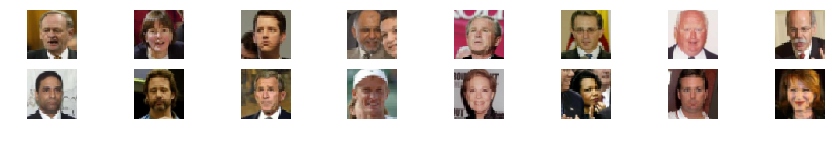

In [6]:
plots(train_batches.next())

In [7]:
from keras.models import Model
from keras.optimizers import Nadam
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Dropout, Activation, Reshape, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, Conv2DTranspose, UpSampling2D

In [8]:
latent_dims = 100
image_dims = (64,64)
gen_mul = 64
disc_mul = 64

In [9]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dims),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

In [10]:
def vae_loss(ground_truth, result):
    ground_truth = K.flatten(ground_truth)
    result = K.flatten(result)
    xent_loss = image_dims[0] * image_dims[0] * metrics.binary_crossentropy(ground_truth, result)
    kl_loss = - 0.5 * K.mean(1 + e_var - K.square(e_mean) - K.exp(e_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [11]:
e_input = Input(shape=(64,64,3))
e = BatchNormalization(axis=3)(e_input)
e = Conv2D(disc_mul*2, (7, 7), activation="relu", padding="same")(e)
e = Conv2D(disc_mul*2, (5, 5), activation="relu", padding="same", strides=(2,2))(e)
e = Conv2D(disc_mul*2, (7, 7), activation="relu", padding="same")(e)
e = Conv2D(disc_mul*2, (5, 5), activation="relu", padding="same", strides=(2,2))(e)
e = BatchNormalization(axis=3)(e)
e = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same")(e)
e = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same", strides=(2,2))(e)
e = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same")(e)
e = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same", strides=(2,2))(e)
e = BatchNormalization(axis=3)(e)
e = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same")(e)
e = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same", strides=(2,2))(e)
e = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same")(e)
e = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same", strides=(2,2))(e)
e = Dropout(0.2)(e)
e = Flatten()(e)
e = Dense(latent_dims*2, activation='relu')(e)
e = Dropout(0.2)(e)
e_mean = Dense(latent_dims)(e)
e_var = Dense(latent_dims)(e)

e_output = Lambda(sampling)([e_mean, e_var])

encoder = Model(e_input, e_output)
encoder.compile(optimizer=Nadam(0.0001), loss='mean_squared_error')

In [12]:
g_input = Input(shape=(latent_dims,))
g = Dense(16*16*gen_mul*4, input_shape=(latent_dims,), kernel_initializer='glorot_normal')(g_input)
g = BatchNormalization()(g)
g = LeakyReLU(0.2)(g)
g = Reshape( [16, 16, gen_mul*4] )(g)
g = Conv2D(gen_mul*2, (5, 5), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = Conv2D(gen_mul*2, (5, 5), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = Conv2D(gen_mul*2, (5, 5), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = BatchNormalization(axis=3)(g)
g = UpSampling2D(size=(2, 2))(g)
g = Conv2D(gen_mul*2, (5, 5), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = Conv2D(gen_mul*2, (5, 5), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = Conv2D(gen_mul*2, (5, 5), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = BatchNormalization(axis=3)(g)
g = UpSampling2D(size=(2, 2))(g)
g = Conv2D(gen_mul, (3, 3), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = Conv2D(gen_mul, (3, 3), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = Conv2D(gen_mul, (3, 3), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g_output = Conv2D(3, (7, 7), activation="sigmoid", padding="same")(g)

generator = Model(g_input, g_output)
generator.compile(optimizer=Nadam(0.0001), loss='mean_squared_error')

In [13]:
ae_output = generator(e_output)
auto_encoder = Model(e_input, ae_output)
auto_encoder.compile(optimizer=Nadam(0.0001), loss=vae_loss)

In [15]:
def auto_generator(generator):
    for n in generator:
        if n.shape[0] == batch_size:
            yield (n,n)
        

In [16]:
auto_encoder.fit_generator(auto_generator(train_batches), steps_per_epoch=train_batches.samples/batch_size, epochs=2)

Epoch 1/2
828/827 [==============================] - 76s - loss: 2527.7537    
Epoch 2/2
828/827 [==============================] - 74s - loss: 2446.1319    


In [17]:
imgs = train_batches.next()

In [18]:
result = auto_encoder.predict(imgs)

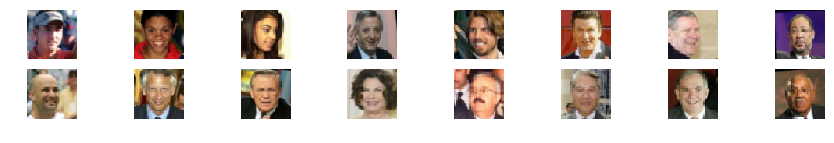

In [19]:
plots(imgs)

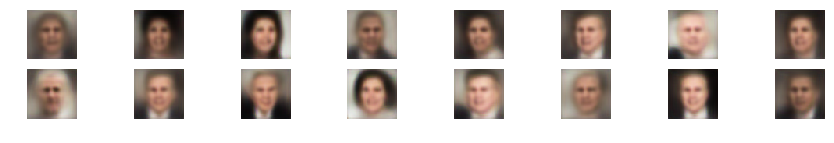

In [20]:
plots(result)

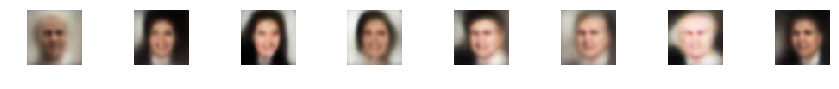

In [21]:
enc_result = encoder.predict(imgs)
interp_result = enc_result[0:8] + enc_result[8:16]
interp_imgs = generator.predict(interp_result)
plots(interp_imgs)

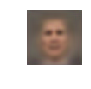

In [22]:
plots(generator.predict(np.zeros((1,latent_dims))))

In [23]:
def get_random_input_for_generator(n,div=5):
    return np.random.normal(0, div, (n,latent_dims))

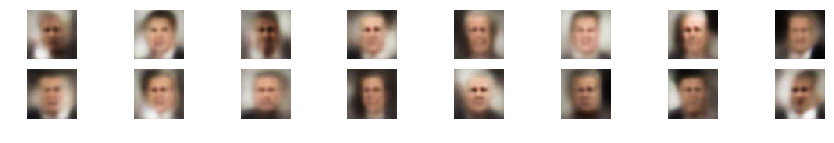

In [28]:
plots(generator.predict(get_random_input_for_generator(16,div=5)))

In [31]:
images = generator.predict(get_random_input_for_generator(16*9,div=5))

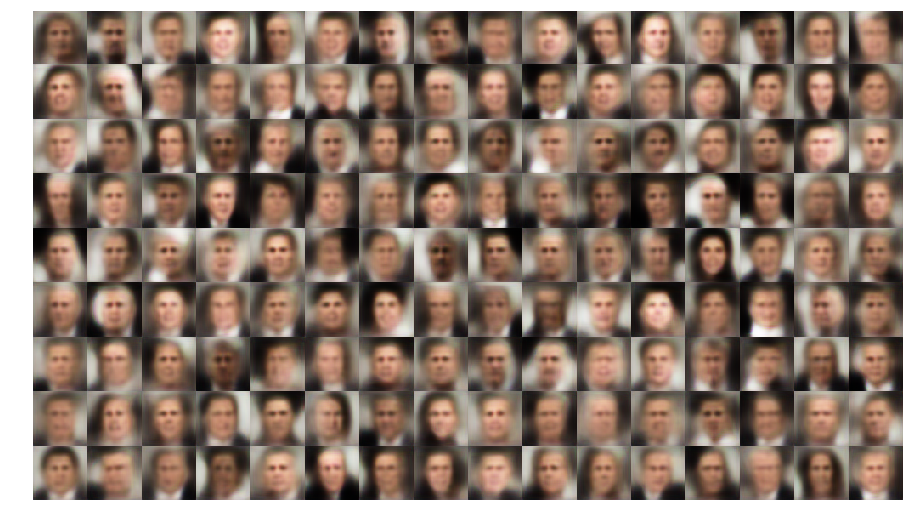

In [41]:
mosaic(images.reshape(9,16,64,64,3))

In [42]:
auto_encoder.save_weights('/data/trained_models/face_gan/variational_auto_encoder_v1.h5')

In [43]:
generator.save_weights('/data/trained_models/face_gan/variational_auto_encoder_generator_v1.h5')